In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# https://www.kaggle.com/code/ahmedosamafawzt/deep-fake-images-detection
import kagglehub
ciplab_real_and_fake_face_detection_path = kagglehub.dataset_download('ciplab/real-and-fake-face-detection')

print('Data source import complete.')


100%|██████████| 431M/431M [00:02<00:00, 207MB/s]

Extracting files...


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Phase 1

## All Used Libraries in Phase 1 0f Project

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

## DataFrame Making for the Data
*Content of the Datafarme***
1. Col Paths 'Image Absolute Path'
2. Col Real '1 if Real, 0 if Fake

In [ ]:
real_path = os.path.join(ciplab_real_and_fake_face_detection_path, 'real_and_fake_face', 'training_real')
fake_path = os.path.join(ciplab_real_and_fake_face_detection_path, 'real_and_fake_face', 'training_fake')

# Store Image's Path and Labels
def load_image_paths_labels(folder_path, label):
    image_paths = []
    labels = []
    for file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, file))
        labels.append(label)
    return image_paths, labels

real_paths, real_labels = load_image_paths_labels(real_path, '1') # Store Real Images
fake_paths, fake_labels = load_image_paths_labels(fake_path, '0') # Store Fake Images

image_paths = real_paths + fake_paths # Merge Real & Fake Paths
labels = real_labels + fake_labels # Merge Real & Fake Labels

RealDf = pd.DataFrame({'Paths': real_paths, 'Labels':real_labels})
FakeDf = pd.DataFrame({'Paths': fake_paths, 'Labels':fake_labels})
MeregedDf = pd.DataFrame({'Paths': image_paths, 'Real':labels})

## Exploreing the Data

In [ ]:
print(f"Real Data: {RealDf.head()}")
print(f"Real Data Size : {RealDf.shape}")
print("-"*98)
print(f"Fake Data: {FakeDf.head()}")
print(f"Fake Data Size: {FakeDf.shape}")
print("-"*98)
print(f"Mereged Data: {MeregedDf.head()}")
print(f"Mereged Data Size: {MeregedDf.shape}")
print("-"*98)

Real Data:                                                Paths Labels
0  /root/.cache/kagglehub/datasets/ciplab/real-an...      1
1  /root/.cache/kagglehub/datasets/ciplab/real-an...      1
2  /root/.cache/kagglehub/datasets/ciplab/real-an...      1
3  /root/.cache/kagglehub/datasets/ciplab/real-an...      1
4  /root/.cache/kagglehub/datasets/ciplab/real-an...      1
Real Data Size : (1081, 2)
--------------------------------------------------------------------------------------------------
Fake Data:                                                Paths Labels
0  /root/.cache/kagglehub/datasets/ciplab/real-an...      0
1  /root/.cache/kagglehub/datasets/ciplab/real-an...      0
2  /root/.cache/kagglehub/datasets/ciplab/real-an...      0
3  /root/.cache/kagglehub/datasets/ciplab/real-an...      0
4  /root/.cache/kagglehub/datasets/ciplab/real-an...      0
Fake Data Size: (960, 2)
--------------------------------------------------------------------------------------------------
Mereged 

## Plotting the Classes in data

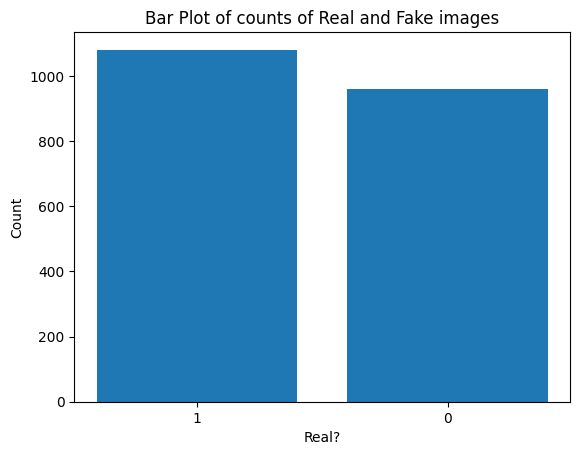

In [ ]:
value_counts = MeregedDf.value_counts('Real')
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Real?')
plt.ylabel('Count')
plt.title('Bar Plot of counts of Real and Fake images')
plt.xticks([0,1])
plt.show()

## Flatten & Normlize the Images
*Flatten the Images "Convert it from Matrix to Array of Values"*

*Then*

*Normalize the Image "Convert Values to Be from 0 to 1"*

In [ ]:
# Normalize the Images, Convert Each Image to List of Values form 0 TO 1
def ProcessingImage(path, target_size=(128, 128), color_mode='rgb'):
    img = load_img(path, color_mode = color_mode, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array/255.0
    return img_array

MeregedDf['image'] = MeregedDf['Paths'].apply(ProcessingImage)

## Divide the Data to Training Data & Testing Data
1. Training Data are 80% of Data
2. Testing Data are 20% of Data

In [ ]:
# COnvert Dataset To Train 80%, Test 20% Data
TrainDf, TestDf = train_test_split(MeregedDf, test_size=0.2, stratify=MeregedDf['Real'], random_state = 123)

XTrain = np.stack(TrainDf['image'].values)
YTrain = TrainDf['Real'].values
XTest = np.stack(TestDf['image'].values)
YTest = TestDf['Real'].values

## The Models Making Using CNNs
*Model 1*
1. Using SGD Optimizier

*Model 2*
1. Using ADAM Optimizier

*Model 1 & Model 2 are Using 6 Layers Arranged as*
1. Conv2D
2. MaxPooling 2D
3. Conv2D
4. MaxPooling 2D
5. Flatten  *It Is Not a Layer*
6. Relu "Activation Function"
7. Sigmoid "Activation Function" *Output Layer*

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

def modelSGD():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = SGD(learning_rate=0.0001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def modelADAM():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Plotting the Performance Result the Model

In [ ]:
def eval(results, model):
    plt.subplot(211)
    plt.subplots_adjust(hspace=0.4)
    plt.title('Cross Entropy Loss')
    plt.plot(results.history['loss'], color='blue', label='train')
    plt.plot(results.history['val_loss'], color='orange', label='test')
    plt.legend()
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(results.history['accuracy'], color='blue', label='train')
    plt.plot(results.history['val_accuracy'], color='orange', label='test')
    plt.xlabel('Epoch')
    plt.legend()
    loss, acc = model.evaluate(XTest, YTest, verbose=0)
    print('Cross Entropy Loss: %.2f' % loss)
    print('Validation Accuracy: %.2f%%' % (acc * 100.0))

## Analysis of the Model Performance
*Using*
1. Recall
2. Percision
3. Confusion Matrix
4. Accuerrcy

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score

def Analysis(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    metrics = ['Accuracy', 'Precision', 'Recall']
    scores = [accuracy, precision, recall]

    plt.bar(metrics, scores)

    for i, score in enumerate(scores):
        plt.text(i, score+0.02, f'{score:.2f}', ha='center', va='bottom', fontsize = 10)

    plt.ylim(0,1.1)
    plt.title('Accuracy, Precision and Recall Scores')
    plt.show()

    conf = confusion_matrix(true_labels, predicted_labels)
    labels = ['Real', 'Fake']

    conf_mat = ConfusionMatrixDisplay(conf, display_labels=labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    conf_mat.plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
    plt.show()

## Visual Sample of the Exsits Images with
1. Real Class
2. Expected Class

In [ ]:
def VisualImages(Labels):
    indices = np.random.choice(len(XTest), 10)

    disp_img = XTest[indices]
    disp_img_lab = YTest[indices]

    fig, axes = plt.subplots(nrows=2, ncols = 5, figsize = (15,8))
    fig.suptitle('Images with their Predicted and Actual Labels', fontsize=20)

    for i, ax in enumerate(axes.flat):
        ax.imshow(disp_img[i])
        ax.axis('off')

        actual_label = 'Real' if disp_img_lab[i] == 1 else 'Fake'
        predicted_label = 'Real' if Labels[i] == 1 else 'Fake'
        ax.set_title('Actual: ' +actual_label +'\n' + 'Predicted: ' + predicted_label)

    plt.tight_layout()
    plt.show()

# Models Testing
## Model 1 "SGD"

In [ ]:
YTrain = YTrain.astype(np.float32)
YTest = YTest.astype(np.float32)
model1 = modelSGD()
model1.summary()
history1 = model1.fit(XTrain, YTrain, epochs=20, batch_size=32, validation_data=(XTest, YTest))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,765,505 (56.33 MB)

 Trainable params: 14,765,505 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5013 - loss: 0.7224 - val_accuracy: 0.6259 - val_loss: 0.6672
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5520 - loss: 0.6928 - val_accuracy: 0.5452 - val_loss: 0.6822
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5548 - loss: 0.6839 - val_accuracy: 0.6284 - val_loss: 0.6500
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5931 - loss: 0.6727 - val_accuracy: 0.6406 - val_loss: 0.6481
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6163 - loss: 0.6473 - val_accuracy: 0.6333 - val_loss: 0.6424
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6319 - loss: 0.6413 - val_accuracy: 0.6357 - val_loss: 0.6505
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6361 - loss: 0.6355 - val_accuracy: 0.5550 - val_loss: 0.6627
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6077 - loss: 0.6505 - val_accuracy: 0.6284 - val_loss

Using SDG Optmizier
Cross Entropy Loss: 0.64
Validation Accuracy: 62.59%


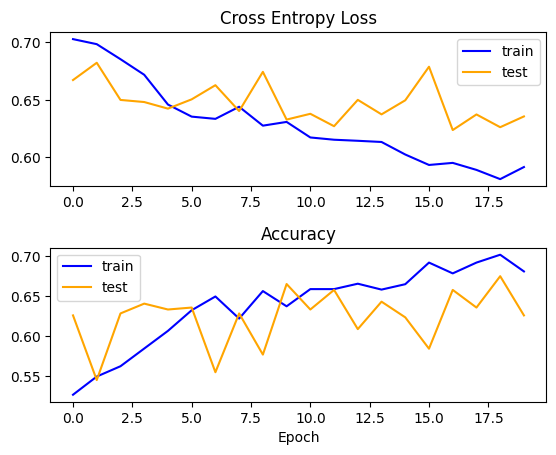

In [ ]:
print("Using SDG Optmizier")
eval(history1, model1)

In [ ]:
SGDPredictions = model1.predict(XTest)
SGDPredictedLabels = np.round(SGDPredictions).flatten().astype(int)
SGDTrueLabels = np.round(YTest).flatten().astype(int)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [ ]:
print(SGDPredictedLabels)
print(SGDTrueLabels)

[1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0
 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0
 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0
 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0
 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1
 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1
 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0
 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1
 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0
 0 1]
[1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0
 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0
 1 0 1 0 0 1 0 0 1 

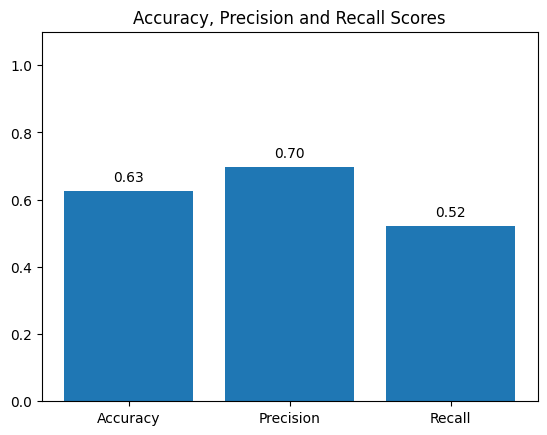

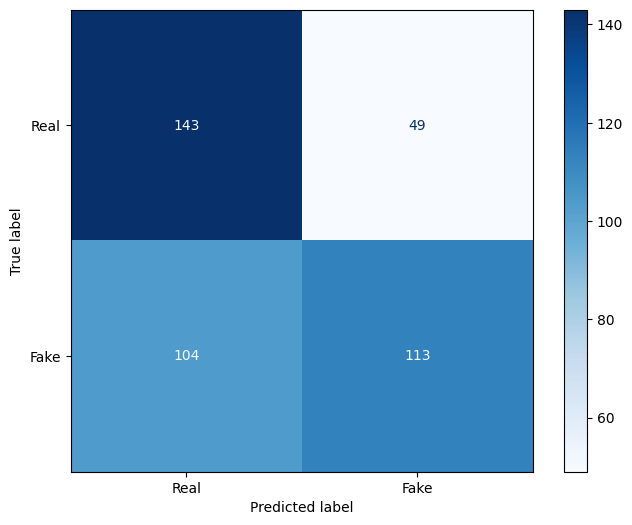

In [ ]:
Analysis(SGDTrueLabels,SGDPredictedLabels)

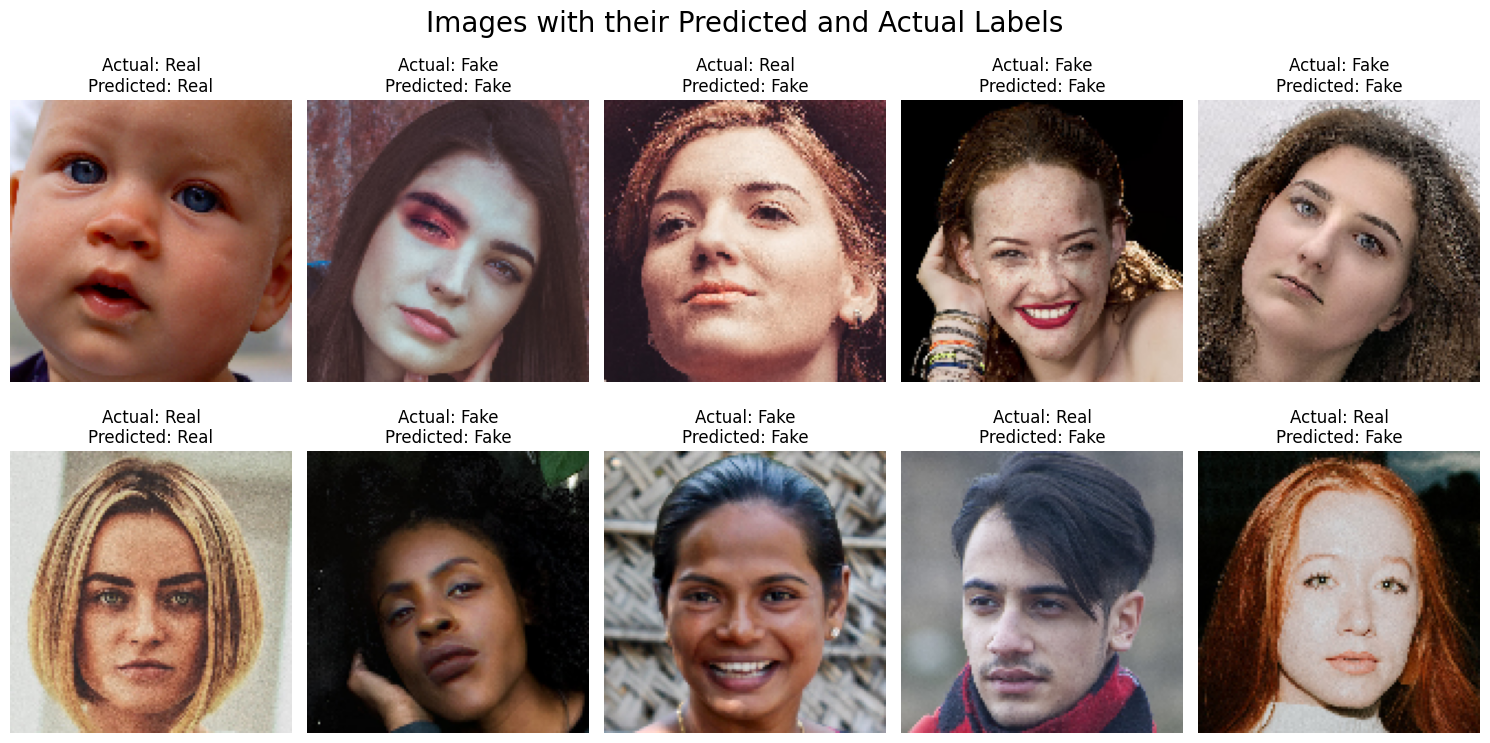

In [ ]:
VisualImages(SGDPredictedLabels)

## Model 2 "ADAM"

In [ ]:
model2 = modelADAM()
model2.summary()
history2 = model2.fit(XTrain, YTrain, epochs=20, batch_size=32, validation_data=(XTest, YTest))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,765,505 (56.33 MB)

 Trainable params: 14,765,505 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5104 - loss: 1.1557 - val_accuracy: 0.5892 - val_loss: 0.6697
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6574 - loss: 0.6368 - val_accuracy: 0.5208 - val_loss: 0.7509
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6175 - loss: 0.6531 - val_accuracy: 0.5599 - val_loss: 0.7157
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7100 - loss: 0.5595 - val_accuracy: 0.6210 - val_loss: 0.6502
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7639 - loss: 0.5028 - val_accuracy: 0.6137 - val_loss: 0.6743
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7975 - loss: 0.4690 - val_accuracy: 0.6259 - val_loss: 0.6581
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8286 - loss: 0.4216 - val_accuracy: 0.5917 - val_loss: 0.7205
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8340 - loss: 0.3950 - val_accuracy: 0.6112 - val_loss:

Using ADAM Optmizier
Cross Entropy Loss: 0.97
Validation Accuracy: 58.92%


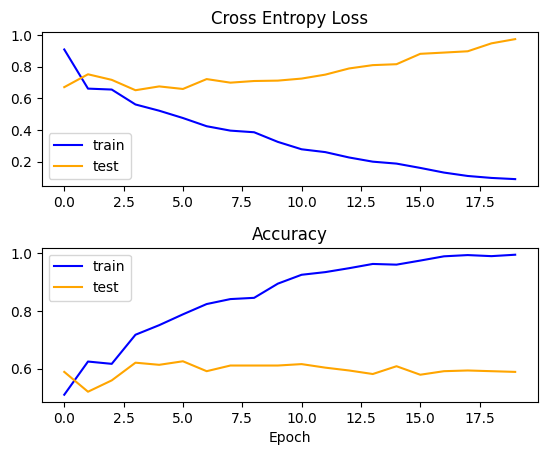

In [ ]:
print("Using ADAM Optmizier")
eval(history2, model2)

In [ ]:
ADAMPredictions = model2.predict(XTest)
ADAMPredictedLabels = np.round(ADAMPredictions).flatten().astype(int)
ADAMTrueLabels = np.round(YTest).flatten().astype(int)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step


In [ ]:
print(ADAMPredictedLabels[:10])
print(ADAMTrueLabels[:10])

[0 1 0 0 0 1 0 0 1 1]
[1 1 1 0 1 1 0 0 0 0]


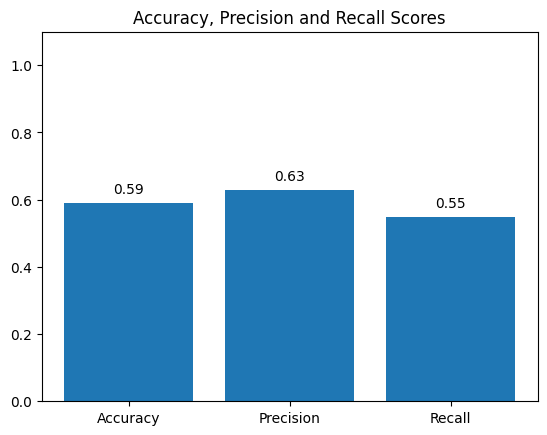

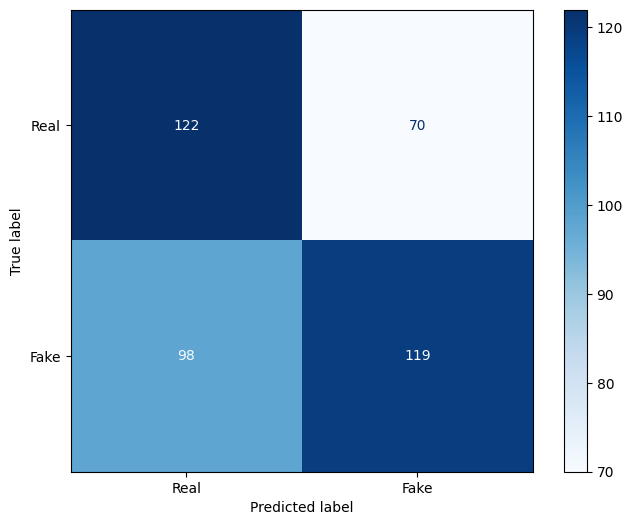

In [ ]:
Analysis(ADAMTrueLabels,ADAMPredictedLabels)

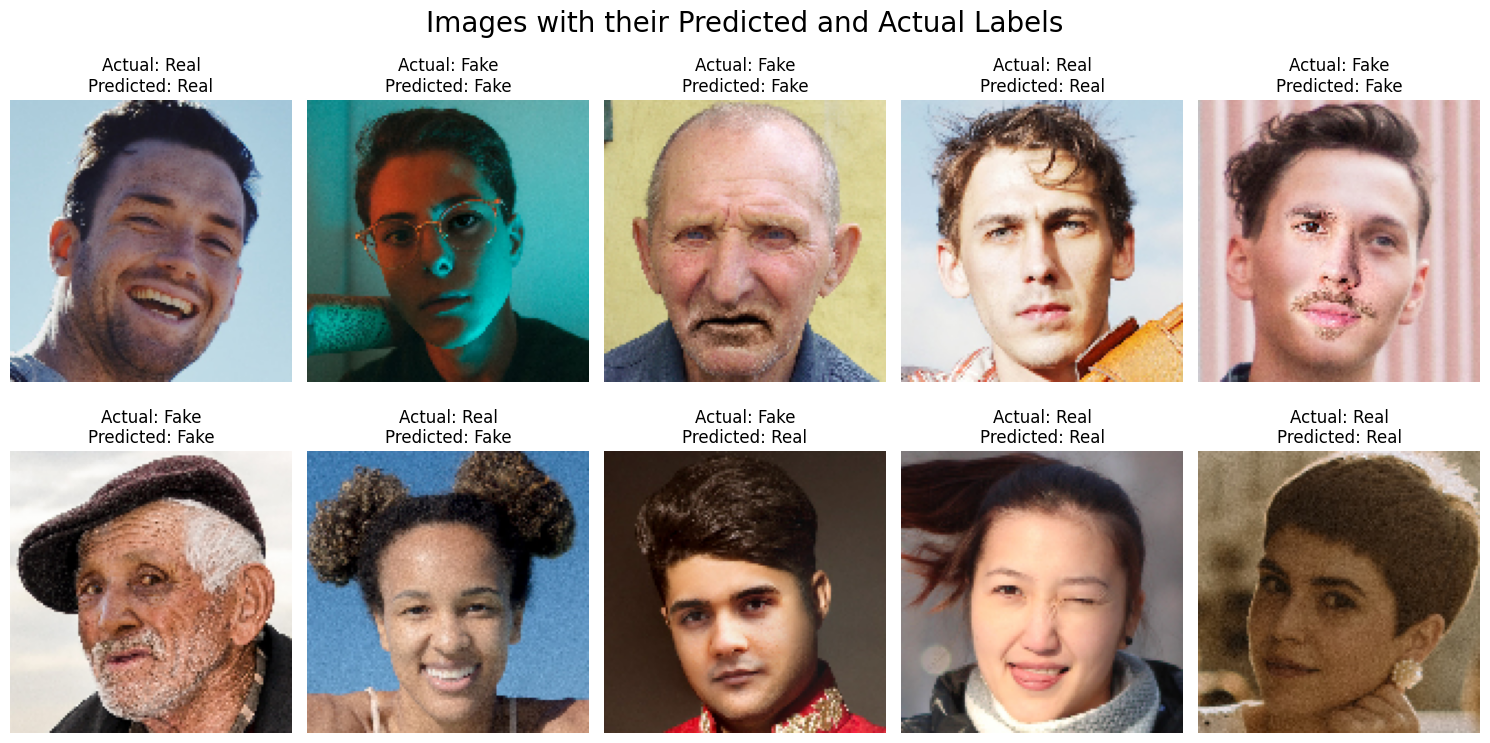

In [ ]:
VisualImages(SGDPredictedLabels)

# Phase 2

## All Used Libraries in Phase 2 of Project

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, MobileNet, InceptionV3
from tensorflow.keras.applications import EfficientNetB0  # Example of another modern architecture
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

## Data Division
1. Train Data 70%
2. Testing Data 15%
3. Validation Data 15%

In [ ]:
# Parameters
img_size = (224, 224)  # Standard input size for most models
batch_size = 32
MeregedDf['Real'] = MeregedDf['Real'].astype(str)
train_df, temp_df = train_test_split(MeregedDf, test_size=0.3, stratify=MeregedDf['Real'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Real'], random_state=42)

# Data Generators
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_dataframe(
    train_df,
    x_col='Paths',
    y_col='Real',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = datagen.flow_from_dataframe(
    val_df,
    x_col='Paths',
    y_col='Real',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = datagen.flow_from_dataframe(
    test_df,
    x_col='Paths',
    y_col='Real',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # No shuffle for test data
)


Found 1428 validated image filenames belonging to 2 classes.
Found 306 validated image filenames belonging to 2 classes.
Found 307 validated image filenames belonging to 2 classes.


# Model Building Function
### Model Layers
1. Pretrained Model's Layers
2. Avg Pooling 2D
3. Drop out *it is not Layer*
4. Sigmoid *Activation Function, Output Layer*

In [ ]:
def ModelBuilding(model, classes=1):
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(classes, activation='sigmoid')(x)
    return Model(inputs, outputs)
performance = {}

## VGG16 Pretrained Model

In [ ]:
print(f"Training VGG16...")
MVGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
MVGG16 = VGG16(weights="/kaggle/input/vggdataset/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
        , include_top=False
        , input_shape=(224, 224, 3))
VGGModel = ModelBuilding(MVGG16)
VGGModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = VGGModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = VGGModel.evaluate(test_data)
performance["VGG16"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

Training VGG16...


ValueError: The `weights` argument should be either `None` (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.  Received: weights=/kaggle/input/vggdataset/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

## ResNet50 Pretrained Model

In [ ]:
print(f"Training ResNet50...")
ResNet50 = ResNet50(weights="/kaggle/input/resnetdataset/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
        , include_top=False
        , input_shape=(224, 224, 3))
ResNetModel = ModelBuilding(ResNet50)
ResNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = ResNetModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = ResNetModel.evaluate(test_data)
performance["ResNet50"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

## DenseNet21 Pretrained Model

In [ ]:
print(f"Training DenseNet121...")
DenseNet121 = DenseNet121(weights="/kaggle/input/desnenetdataset/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
            , include_top=False
            , input_shape=(224, 224, 3))
DenseNetModel = ModelBuilding(DenseNet121)
DenseNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = DenseNetModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = DenseNetModel.evaluate(test_data)
performance["DenseNet121"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

## MobileNet Pretrained Model

In [ ]:
print(f"Training MobileNet...")
MobileNet = MobileNet(weights="/kaggle/input/mobilenetdataset/mobilenet_1_0_224_tf_no_top.h5"
        , include_top=False
        , input_shape=(224, 224, 3))
MobileNetModel = ModelBuilding(MobileNet)
MobileNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = MobileNetModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = MobileNetModel.evaluate(test_data)
performance["MobileNet"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

## Inception Pretrained Model

In [ ]:
print(f"Training InceptionV3...")
InceptionV3 = InceptionV3(weights="/kaggle/input/inceptiondataset/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
            , include_top=False
            , input_shape=(224, 224, 3))
InceptionV3Model = ModelBuilding(InceptionV3)
InceptionV3Model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = InceptionV3Model.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = InceptionV3Model.evaluate(test_data)
performance["InceptionV3"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

In [ ]:
performance

# Fine Tune Pretrained Model
### Model Layers
1. Pretrained Model's Layers *Remove Last 2 Layers in Each Model*
2. Avg Pooling 2D
3. Drop out *it is not Layer*
4. Sigmoid *Activation Function, Output Layer*

In [ ]:
def FineTuneModel(base_model, num_classes=1, layers_to_unfreeze=2):
    base_model.trainable = True
    for layer in base_model.layers[:-layers_to_unfreeze]:
        layer.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    return Model(inputs, outputs)
FineTunePerformance = {}

## VGG16 Model Using Fine Tune For Last 2 Final Layer

In [ ]:
print(f"Training VGG16...")
MVGG16 = VGG16(weights="/kaggle/input/vggdataset/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
        , include_top=False
        , input_shape=(224, 224, 3))
VGGModel = FineTuneModel(MVGG16)
VGGModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = VGGModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = VGGModel.evaluate(test_data)
FineTunePerformance["VGG16"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

## ResNet50 Model Using Fine Tune For Last 2 Final Layer

In [ ]:
print(f"Training ResNet50...")
ResNet50 = ResNet50(weights="/kaggle/input/resnetdataset/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
        , include_top=False
        , input_shape=(224, 224, 3))
ResNetModel = FineTuneModel(ResNet50)
ResNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = ResNetModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = ResNetModel.evaluate(test_data)
FineTunePerformance["ResNet50"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

## DenseNet121 Model Using Fine Tune For Last 2 Final Layer

In [ ]:
print(f"Training DenseNet121...")
DenseNet121 = DenseNet121(weights="/kaggle/input/desnenetdataset/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
            , include_top=False
            , input_shape=(224, 224, 3))
DenseNetModel = FineTuneModel(DenseNet121)
DenseNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = DenseNetModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = DenseNetModel.evaluate(test_data)
FineTunePerformance["DenseNet121"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

## MobileNet Model Using Fine Tune For Last 2 Final Layer

In [ ]:
print(f"Training MobileNet...")
MobileNet = MobileNet(weights="/kaggle/input/mobilenetdataset/mobilenet_1_0_224_tf_no_top.h5"
        , include_top=False
        , input_shape=(224, 224, 3))
MobileNetModel = FineTuneModel(MobileNet)
MobileNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = MobileNetModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = MobileNetModel.evaluate(test_data)
FineTunePerformance["MobileNet"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

## Inception Model Using Fine Tune For Last 2 Final Layer

In [ ]:
print(f"Training InceptionV3...")
InceptionV3 = InceptionV3(weights="/kaggle/input/inceptiondataset/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
            , include_top=False
            , input_shape=(224, 224, 3))
InceptionV3Model = FineTuneModel(InceptionV3)
InceptionV3Model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = InceptionV3Model.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = InceptionV3Model.evaluate(test_data)
FineTunePerformance["InceptionV3"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

In [ ]:
FineTunePerformance

In [ ]:
def ConcLayersModelBuilding(model, classes=1):
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(classes, activation='sigmoid')(x)
    return Model(inputs, outputs)
ConvLayersPerformance = {}

In [ ]:
print(f"Training VGG16...")
MVGG16 = VGG16(weights="/kaggle/input/vggdataset/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
        , include_top=False
        , input_shape=(224, 224, 3))
VGGModel = ConcLayersModelBuilding(MVGG16)
VGGModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = VGGModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = VGGModel.evaluate(test_data)
ConvLayersPerformance["VGG16"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

In [ ]:
print(f"Training ResNet50...")
ResNet50 = ResNet50(weights="/kaggle/input/resnetdataset/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
        , include_top=False
        , input_shape=(224, 224, 3))
ResNetModel = ConcLayersModelBuilding(ResNet50)
ResNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = ResNetModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = ResNetModel.evaluate(test_data)
ConvLayersPerformance["ResNet50"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

In [ ]:
print(f"Training DenseNet121...")
DenseNet121 = DenseNet121(weights="/kaggle/input/desnenetdataset/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
            , include_top=False
            , input_shape=(224, 224, 3))
DenseNetModel = ConcLayersModelBuilding(DenseNet121)
DenseNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = DenseNetModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = DenseNetModel.evaluate(test_data)
ConvLayersPerformance["DenseNet121"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

In [ ]:
print(f"Training MobileNet...")
MobileNet = MobileNet(weights="/kaggle/input/mobilenetdataset/mobilenet_1_0_224_tf_no_top.h5"
        , include_top=False
        , input_shape=(224, 224, 3))
MobileNetModel = ConcLayersModelBuilding(MobileNet)
MobileNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = MobileNetModel.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = MobileNetModel.evaluate(test_data)
ConvLayersPerformance["MobileNet"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

In [ ]:
print(f"Training InceptionV3...")
InceptionV3 = InceptionV3(weights="/kaggle/input/inceptiondataset/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
            , include_top=False
            , input_shape=(224, 224, 3))
InceptionV3Model = ConcLayersModelBuilding(InceptionV3)
InceptionV3Model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = InceptionV3Model.fit(train_data, validation_data=val_data, epochs=5)
test_loss, test_acc = InceptionV3Model.evaluate(test_data)
ConvLayersPerformance["InceptionV3"] = {"Test Loss": test_loss, "Test Accuracy": test_acc}

In [ ]:
ConvLayersPerformance

In [ ]:
NormalPerformance = {
    'VGG16': {'Test Loss': 0.6713720560073853,
      'Test Accuracy': 0.5863192081451416},
    'ResNet50': {'Test Loss': 0.6884172558784485,
      'Test Accuracy': 0.534201979637146},
    'DenseNet121': {'Test Loss': 0.6847890019416809,
      'Test Accuracy': 0.5635179281234741},
    'MobileNet': {'Test Loss': 0.6458680629730225,
      'Test Accuracy': 0.638436496257782},
    'InceptionV3': {'Test Loss': 0.6596470475196838,
      'Test Accuracy': 0.6188924908638}
}

FineTunePerformance = {
    'VGG16': {'Test Loss': 0.6124237179756165,
      'Test Accuracy': 0.6612377762794495},
    'ResNet50': {'Test Loss': 0.6926276683807373,
      'Test Accuracy': 0.4788273572921753},
    'DenseNet121': {'Test Loss': 0.7066729664802551,
      'Test Accuracy': 0.5602605938911438},
    'MobileNet': {'Test Loss': 0.637444794178009,
      'Test Accuracy': 0.6254071593284607},
    'InceptionV3': {'Test Loss': 0.7406190037727356,
      'Test Accuracy': 0.5407165884971619}
}

ConvLayersPerformance = {
    'VGG16': {'Test Loss': 0.6391993165016174,
      'Test Accuracy': 0.638436496257782},
    'ResNet50': {'Test Loss': 0.6900039911270142,
      'Test Accuracy': 0.5309446454048157},
    'DenseNet121': {'Test Loss': 0.6528996825218201,
      'Test Accuracy': 0.6188924908638},
    'MobileNet': {'Test Loss': 0.6958224177360535,
      'Test Accuracy': 0.6221498250961304},
    'InceptionV3': {'Test Loss': 0.6477277278900146,
      'Test Accuracy': 0.6221498250961304}
}

In [ ]:
normal_df = pd.DataFrame(NormalPerformance).T
fine_tune_df = pd.DataFrame(FineTunePerformance).T
conv_layers_df = pd.DataFrame(ConvLayersPerformance).T

combined_df = pd.concat([normal_df.add_suffix(' (Normal)'),
                         fine_tune_df.add_suffix(' (Fine-Tune)'),
                         conv_layers_df.add_suffix(' (Conv Layers)')], axis=1)

print("Comparison Table:")
print(combined_df)

models = NormalPerformance.keys()
metrics = ['Test Loss', 'Test Accuracy']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.title(f"Comparison of {metric} Across Models")

    plt.plot(models, [NormalPerformance[model][metric] for model in models], label='Normal', marker='o')
    plt.plot(models, [FineTunePerformance[model][metric] for model in models], label='Fine-Tune', marker='s')
    plt.plot(models, [ConvLayersPerformance[model][metric] for model in models], label='Conv Layers', marker='^')

    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()